In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Data preprocessing
firstly we will explore the data and taje in considerations columns we nedd and drop others we don't

In [2]:
df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


### it appears that the unamed is indexing so we will drop it 

In [3]:
df=df.drop("Unnamed: 0",axis=1)
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 94.5 KB


In [5]:
df.describe()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.00000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,76.645423,16.995365,0.849363,49.400000,0.181924,0.107764,12.13905,28.002317,18.298957,11.840093,2.993048,0.998841,0.995365,0.125145
std,39.200264,7.809951,0.726062,15.079203,0.386005,0.310261,3.99787,7.473231,2.864064,1.183771,0.127251,0.034040,2.358767,0.331075
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,11.000000,0.000000,40.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,87.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,110.000000,24.000000,1.000000,57.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.00000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


### from describe there are some unusual beahviours observed as :
- the min in the diff coulmn is -ve value
- symptom 6 has its percentiles and max equal to each other
- gender have a max of 2

### fristly we explore the diff as it's descrioed in the project statement that it's the time the symptoms appeared so it can't be less than 0

In [6]:
print(df[df['diff_sym_hos'] <0])

     location  country  gender   age  vis_wuhan  from_wuhan  symptom1  \
223        56       18       1  35.0          0           0         6   
240       128       18       1  65.0          0           0         6   

     symptom2  symptom3  symptom4  symptom5  symptom6  diff_sym_hos  result  
223        31        19        12         3         1            -1       0  
240        31        19        12         3         1            -5       0  


### next we explore the values of sympotom 6 and the gender

In [7]:
print(df['symptom6'].value_counts())

symptom6
1    862
0      1
Name: count, dtype: int64


#### as can be seen there's only 1 zero so the symptom doesn't effect any model so we will drop it

In [8]:
gender = df['gender'].value_counts()
print(gender)

gender
1    389
0    302
2    172
Name: count, dtype: int64


#### an undefined variable 2  exists with big frequency so that makes it redundant to make sure we will pie plot the percentages

([<matplotlib.patches.Wedge at 0x2964325bd60>,
 [Text(-0.16950666640350712, -1.0868613021194427, '1'),
  Text(0.7742700740940995, 0.7813487392722392, '0'),
  Text(-0.8913287401236816, 0.6446185515710283, '2')],
 [Text(-0.09245818167464025, -0.592833437519696, '45.08%'),
  Text(0.42232913132405425, 0.42619022142122137, '34.99%'),
  Text(-0.48617931279473536, 0.3516101190387427, '19.93%')])

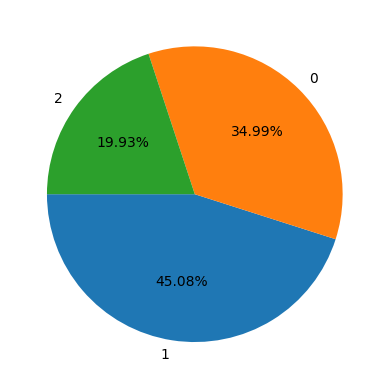

In [9]:
labels=[1,0,2] # as one appeared before 0 in the data
plt.pie(gender,labels=labels,startangle=180,autopct="%2.2f%%")

## we can drop symptom 6 as it doesn't affect the data and gender can be kept or dropped

In [10]:
X = df.drop(columns=['result' ,'symptom6'],axis = 1).values #['gender' ,'result','symptom6']
y = df['result'].values

## splitting into train , validate and test

In [11]:
from sklearn.model_selection import train_test_split
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=50)
X_train,X_validate,y_train,y_validate = train_test_split(X_train,y_train,test_size=0.1,random_state=50)

### feautre scaling
 - after testing each model will be scalled indvidually

# importing metrics and validations to be used as required

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , auc
from sklearn.metrics import roc_curve , RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
score_idx = ["acc","recall","percision","f1 score","AUC"]
comp={}

## important functions

In [30]:
def scores(y_pred,y_true=y_test):
    res = []
    res +=[accuracy_score(y_true=y_true,y_pred=y_pred)]
    res += [recall_score(y_true=y_true,y_pred=y_pred)]
    res += [precision_score(y_true=y_true,y_pred=y_pred)]
    res += [f1_score(y_true=y_true,y_pred=y_pred)]
    print(f"accuracy score :{res[0]:0.3f} ")
    print(f"recall score :{res[1]:0.3f}     percesion score : {res[2]:0.3f}")
    print(f"f1 score :{res[-1]:0.3f} ")
    return res

In [31]:
def confmat(y_pred,y_true=y_test):
    cm=confusion_matrix(y_pred=y_pred,y_true=y_true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

In [32]:
def rocgraph(y_pred,name,y_test=y_test):
    fpr, tpr, _=roc_curve(y_test,y_pred)
    roc=auc(fpr,tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc,estimator_name=name)
    display.plot()
    return (roc)

In [16]:
#TODO discover the problem ---- > inconsisitent
def kf_validation(model,scoring,n_splits=10):
    kf = KFold(n_splits=n_splits,shuffle=True,random_state=50)
    best_model = None
    best_rec = 0.0
    methods = {"acc":accuracy_score,
               "rec":recall_score,
               "pre":precision_score}
    score = methods[scoring]
    records=[]
    for tr_idx ,test_idx in kf.split(X_train) :

        ## splitting to train and validation
        xtr,xte=X_train[tr_idx],X_train[test_idx]
        ytr,yte=y_train[tr_idx],y_train[test_idx]

        #training
        classifier_k = model
        print(score)
        classifier_k.fit(xtr,ytr)

        #testing
        y_hat = classifier_k.predict(xte)

        #recording and choosing best model
        records+=[score(y_pred=y_hat,y_true=yte)]
        if records[-1] > best_rec :
            best_rec = records[-1]
            best_model = classifier_k
        
    print(f"best {scoring} :{best_rec} ")
    print(f"avg {scoring} : {np.mean(records)}")
    return best_model
    
    

### after searching we found we can do dimensionality reduction to draw a decision boundary

In [17]:
from sklearn.decomposition import PCA

In [18]:
def decision_boundary(model) :
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test)
    h = .02  # step size in the mesh
    x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
    y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain predictions for each point in the meshgrid
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

    # Reshape the predictions for contour plotting
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)

    # Scatter plot of training data points
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.RdYlBu)

    plt.title('Decision Boundary Visualization using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Logestic Regression

### logestic regression reached max iteration with kfolds for validation and without, so we apply standrixation for feautres  and will use grid search to look for best options 

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_log = sc.fit_transform(X_train)
X_test_log = sc.transform(X_test)
X_val_log = sc.transform(X_validate)

### logestic regression with accuracy as its scoring value without any validation method

In [20]:
from sklearn.linear_model import LogisticRegression
classifierLR = LogisticRegression()
classifierLR.fit(X_train_log,y_train)

LogisticRegression()

#### test

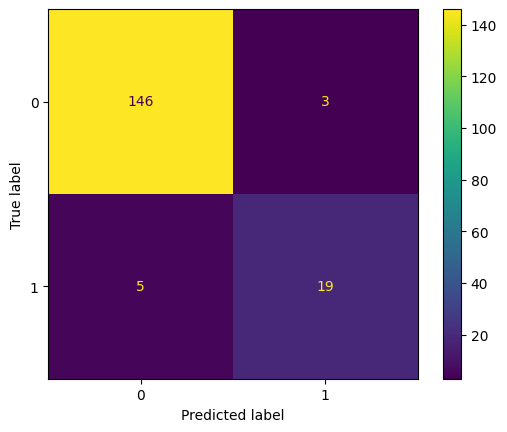

accuracy score :0.954 
recall score :0.792     percesion score : 0.864
f1 score :0.826 


In [21]:
y_LR = classifierLR.predict(X_test_log)
confmat(y_LR)
LR_scores = scores(y_LR)

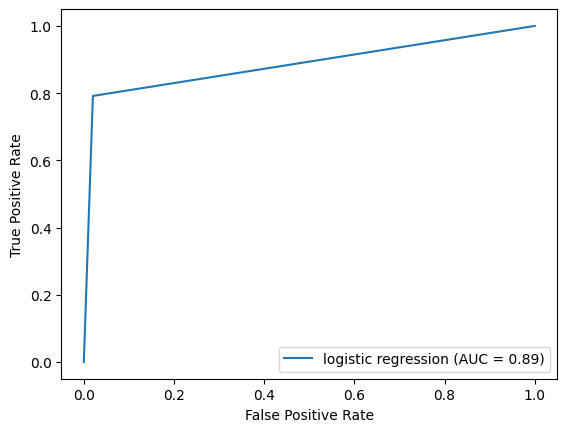

In [24]:
a= rocgraph(y_LR,'logistic regression')
LR_scores+=[a]
comp['logistic regression']=LR_scores

In [ ]:
decision_boundary(classifierLR)

#### validate

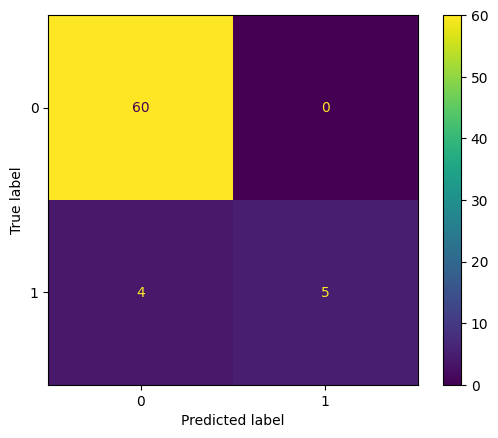

accuracy score :0.942 
recall score :0.556     percesion score : 1.000
f1 score :0.714 


[0.9420289855072463, 0.5555555555555556, 1.0, 0.7142857142857143]

In [33]:
y_LR = classifierLR.predict(X_val_log)
confmat(y_LR,y_validate)
scores(y_LR,y_validate)

### using k-folds cross validation

best recall :  0.8571428571428571
avg rec :  0.5723809523809524


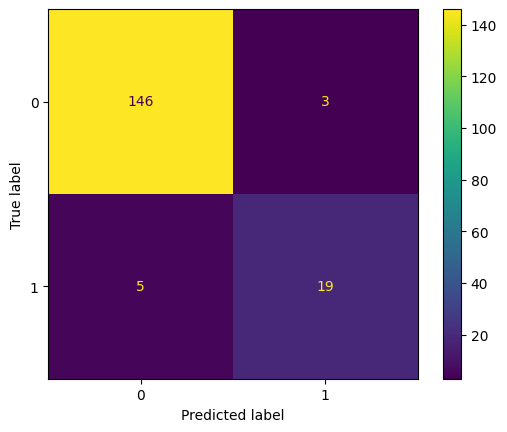

In [34]:
kf = KFold(n_splits=10,shuffle=True,random_state=50)
best_model = None
best_rec = 0.0
recs=[]
for tr_idx ,test_idx in kf.split(X_train_log) :

    xtr,xte=X_train_log[tr_idx],X_train_log[test_idx]
    ytr,yte=y_train[tr_idx],y_train[test_idx]

    classifier_k = LogisticRegression()
    classifier_k.fit(xtr,ytr)
    y_hat = classifier_k.predict(xte)
    recs+=[recall_score(y_pred=y_hat,y_true=yte)]
    if recs[-1] > best_rec :
        best_rec = recs[-1]
        best_model = classifier_k
print("best recall : ", best_rec)
print("avg rec : ", np.mean(recs))
best_model.fit(X_train_log, y_train)
y_hat = best_model.predict(X_test_log)
confmat(y_hat)


accuracy score :0.954 
recall score :0.792     percesion score : 0.864
f1 score :0.826 


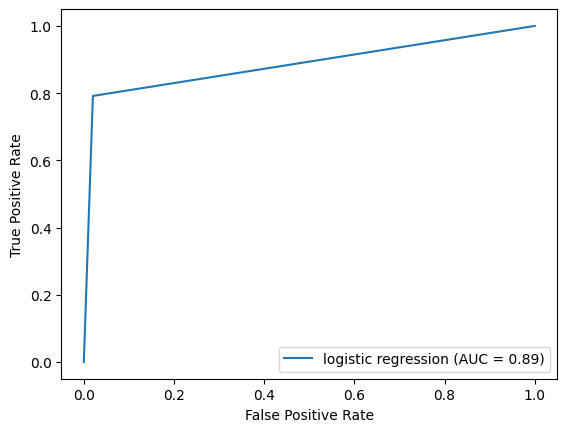

In [35]:
a = rocgraph(y_hat,'logistic regression')
KFold_LR_scores = scores(y_hat)
KFold_LR_scores += [a]
comp['logistic regression k']=KFold_LR_scores

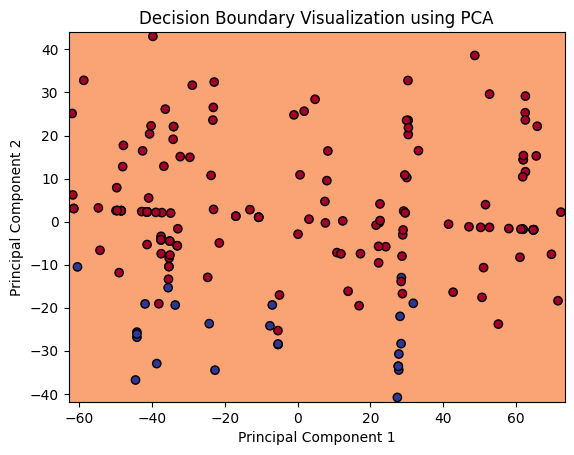

In [36]:
decision_boundary(best_model)

#### validate

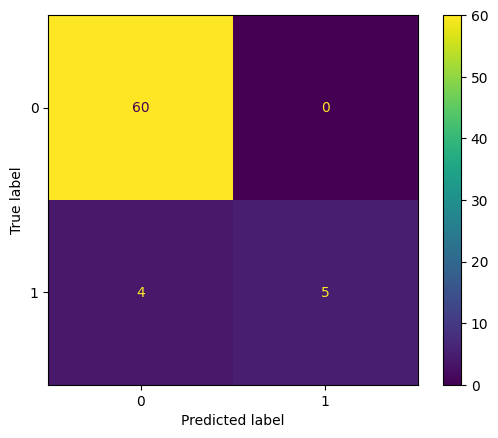

accuracy score :0.942 
recall score :0.556     percesion score : 1.000
f1 score :0.714 


[0.9420289855072463, 0.5555555555555556, 1.0, 0.7142857142857143]

In [38]:
y_LR = classifierLR.predict(X_val_log)
confmat(y_LR,y_validate)
scores(y_LR,y_validate)

### using GridSearch to find the best paramters to pass into the object creation

### for params we will use : 
 - C : the defintion in they API is :
 > Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization 
  - we already used standrization so we will check if it needs to be multiblied by a number so we will start at 1 to 10000


In [39]:
param_grid = {
    'C': [1,10,100,1000,10000],
}
best_model = LogisticRegression()
grid_search = GridSearchCV(best_model, param_grid, verbose = 1, cv=10,scoring='recall')


# Fit the model to the training data
grid_search.fit(X_train_log, y_train)

# Get the best parameters
best_params = list(grid_search.best_params_.values())
print(best_params)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[100]


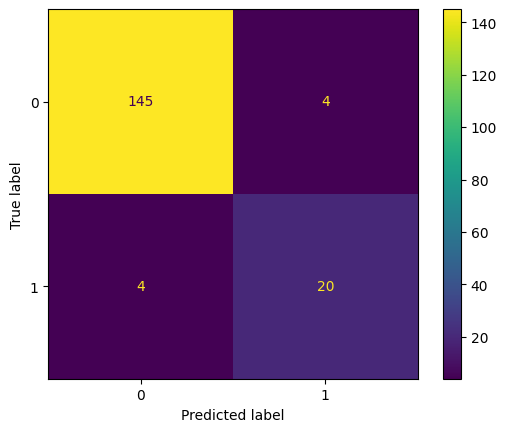

In [40]:
best_model=LogisticRegression(C=best_params[0])
best_model.fit(X_train_log, y_train)
y_hat = best_model.predict(X_test_log)
confmat(y_hat)

accuracy score :0.954 
recall score :0.833     percesion score : 0.833
f1 score :0.833 


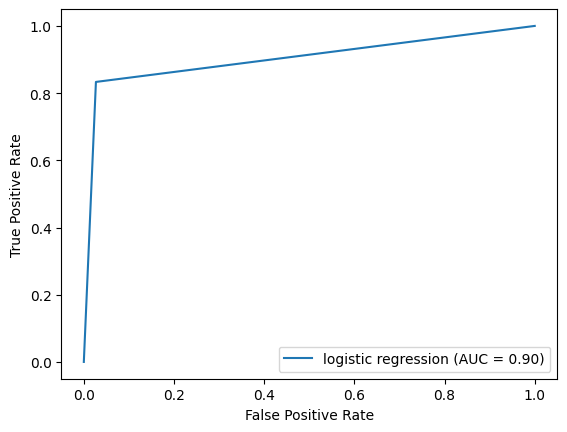

In [41]:
a = rocgraph(y_hat,'logistic regression')
KFold_LR_scores = scores(y_hat)
KFold_LR_scores += [a]
comp['logistic regression grid']=KFold_LR_scores

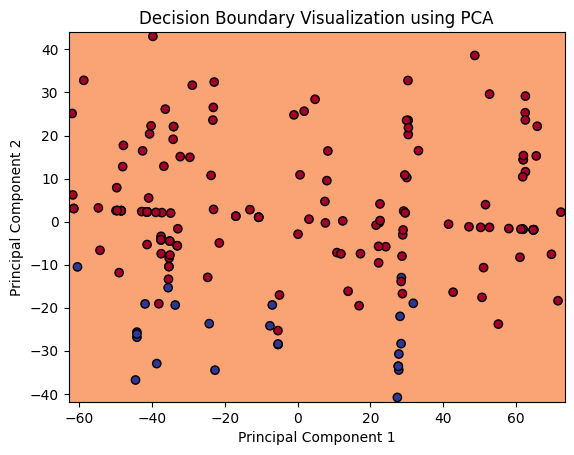

In [42]:
decision_boundary(best_model)

#### validate

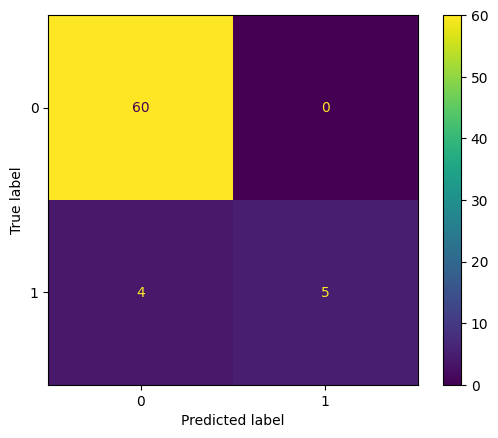

accuracy score :0.942 
recall score :0.556     percesion score : 1.000
f1 score :0.714 


In [43]:
y_LR = classifierLR.predict(X_val_log)
confmat(y_LR,y_true=y_validate)
LR_scores = scores(y_LR,y_validate)


# summary

In [44]:
res_df = pd.DataFrame.from_dict(comp)
res_df.index = score_idx

In [45]:
res_df

,logistic regression,logistic regression k,logistic regression grid
acc,0.953757,0.953757,0.953757
recall,0.791667,0.791667,0.833333
percision,0.863636,0.863636,0.833333
f1 score,0.826087,0.826087,0.833333
AUC,0.885766,0.885766,0.903244


# grid search is much better after trading percision for recall giving a higher AUC and F1 score